# Gravitational Waves SNR

### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.




### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with deep-learning: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). Next time we look into deep learning.

In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2. Could you do better? If yes, please tell me how!

I should have really put a figure with my ROC in that paper but I didn't! Deep learning people liked the accuracy and I just went with the flow.


### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import corner
import os
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import seaborn as sns
import h5py


from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

Take the data and build a dictionary

In [2]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
data_sub = []
N_used = 3000

for name in (list(dataset.keys())):
    data_sub.append(dataset[name][:N_used])

In [3]:
print(list(dataset.keys()))
print(len(data_sub))
print(len(data_sub[0]))

['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
15
3000


Here I use pandas to get the data organized

In [4]:
data_sub = pd.DataFrame(np.transpose(data_sub))
data_sub.columns = list(dataset.keys())
print(data_sub)

         chi1x     chi1y     chi1z     chi2x     chi2y     chi2z       dec  \
0    -0.307201  0.276165 -0.430760 -0.161114 -0.092334 -0.414647 -0.329671   
1    -0.734712 -0.498493 -0.298162  0.057532 -0.844992  0.014708  0.526740   
2    -0.057831 -0.703796 -0.354512 -0.215538  0.016323  0.130543  0.315799   
3     0.015260 -0.202467 -0.492768 -0.237033 -0.365363 -0.876192  0.432105   
4    -0.016731  0.007848  0.005007  0.147519  0.231879  0.086716 -0.458711   
...        ...       ...       ...       ...       ...       ...       ...   
2995 -0.091420  0.099775  0.148377 -0.190059 -0.100585  0.000641 -0.479963   
2996  0.367781  0.795361  0.060592 -0.453191 -0.025618 -0.539645 -0.755488   
2997  0.546230 -0.035668  0.357633 -0.391463  0.499890 -0.032438 -0.832481   
2998 -0.011416  0.285774  0.158212 -0.022294  0.024828 -0.003975  0.117207   
2999 -0.444440 -0.459518 -0.083262 -0.247263 -0.404604  0.478625 -0.307026   

      det      iota        mtot       psi         q        ra  

Here the data I will use, without snr and detection labels

In [5]:
data = data_sub[['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']]
print(data.shape)

(3000, 12)


In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

print(scaled_data.shape)

(3000, 12)


What I want to do here are these steps:
- Try to reduce the dimensionality of the problem using PCA or t-SNE comparing the results.
- Run a classifier (LR) using the full dataset and then the dimensionaly reduced dataset and compare the result
- Run a Regressor on SNR instead of a classifier on 'det'

### PCA

In [7]:
u_pca = PCA(n_components = 12) 
pca = PCA(n_components = 12) 
final_pca_features = pca.fit_transform(scaled_data)
unscaled_pca_features = u_pca.fit_transform(data)

print(final_pca_features.shape)

(3000, 12)


Text(0.5, 1.0, 'Unscaled Components Imporance')

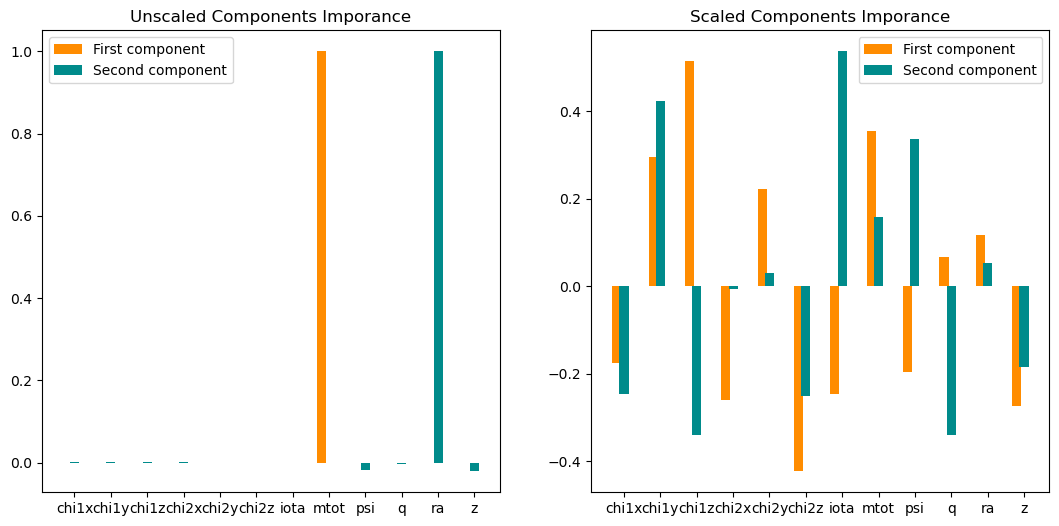

In [8]:
names = ['chi1x' , 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']
x = np.arange(len(names))
fig = plt.figure(figsize=(13,6))

ax = plt.subplot(122)
plt.bar(x, pca.components_[0], width = 0.25, color = 'darkorange', label = 'First component')
plt.bar(x + 0.4/2, pca.components_[1], width = 0.25, color = 'darkcyan', label = 'Second component')
plt.legend()
plt.xticks(x + 0.4/2, names)
plt.title('Scaled Components Imporance')

ax = plt.subplot(121)
plt.bar(x, u_pca.components_[0], width = 0.25, color = 'darkorange', label = 'First component')
plt.bar(x + 0.4/2, u_pca.components_[1], width = 0.25, color = 'darkcyan', label = 'Second component')
plt.legend()
plt.xticks(x + 0.4/2, names)
plt.title('Unscaled Components Imporance')

The variance ratio scales linearly with the components, there is no falttening.

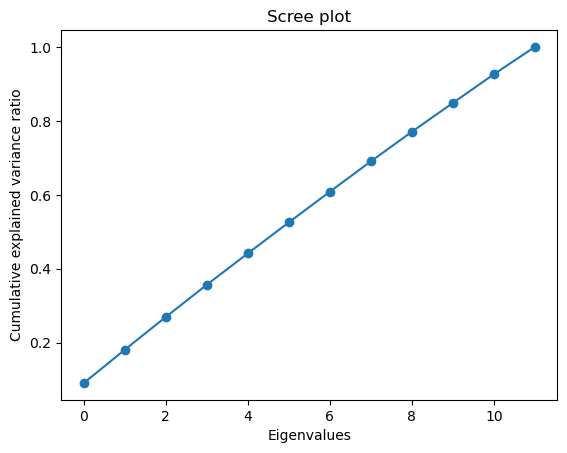

In [9]:
# Scree plot
evals = pca.explained_variance_ratio_ 
plt.title('Scree plot')
plt.xlabel('Eigenvalues')
plt.ylabel('Cumulative explained variance ratio')
plt.plot(evals.cumsum(), marker = 'o')
plt.show()

I'll use all the components, in this way I just did a rotation: because the plot is linear, if I remove one component I'll loose variance 
Looking at the first two components

<Axes: >

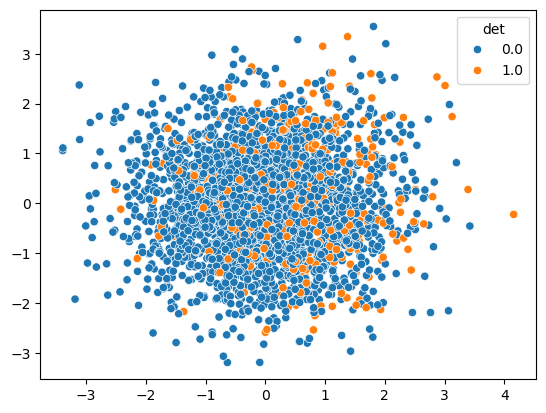

In [10]:
sns.scatterplot(x = final_pca_features[:,0], y = final_pca_features[:,1], hue = data_sub['det'])

### T-SNE

I can try with t-SNE to see if it performs better

In [11]:
tsne = TSNE(n_components = 6, method = 'exact', learning_rate = 200)

tsne_data = tsne.fit_transform(scaled_data)

<Axes: >

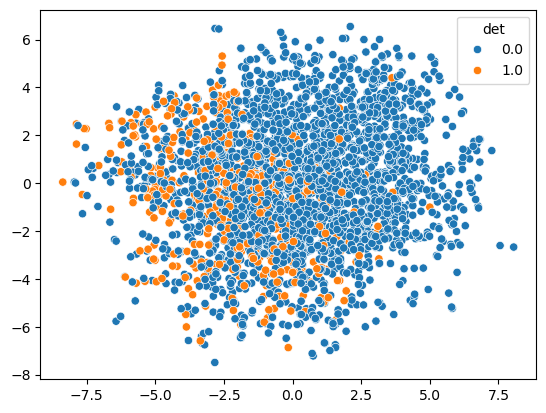

In [12]:
sns.scatterplot(x = tsne_data[:, 0], y = tsne_data[:,1], hue = data_sub['det'])

From the plots, it seems that the t-sne doesn't do better on this dataset than PCA

### Randfom Forest Classifier (RFC) on full dataset

At first, I try to run it on the full dataset. But before I want to split everything in training, cv and test set

In [19]:
X_train, x_test, Y_train, y_test = train_test_split(scaled_data, data_sub['det'], test_size=0.2, random_state=42)
cv_x, x_train, cv_y, y_train =  train_test_split(X_train, Y_train, test_size=0.5, random_state=42)

Of course, I need to CV the RFC for the depth of the tree. I report three different types of CV: using **cross_validate** using **GridSearch** and using the **RMS**. The last option doesn't seems good because it uses the RMS error, which is not a good metric for classification problems in general. It's better to use the missclassification score (or the accuracy score) implemented in the RFC and used as default metric by GridSearch or cross_validate: The two implementations give comparable results.

Moreover, it's possible to use the Information Gain of the splits to cross validate.

In [20]:
def RMS (X, Y, func):

    return np.sqrt( np.sum(( Y - func.predict(X))**2) / len(X))

In [27]:
depth = np.linspace(1, 11, 10, dtype = int)
scores_cv = []
scores_train = []

cv_x, cv_y = shuffle(cv_x, cv_y)

for i in depth:

    clf = RandomForestClassifier(max_depth = i, random_state = 0)
    clf.fit(cv_x, cv_y)
 
    cv_results = cross_validate(clf, cv_x, cv_y, cv = 5, return_train_score = True)
    scores_cv.append(np.mean(cv_results['test_score']))
    scores_train.append(np.mean(cv_results['train_score']))
    

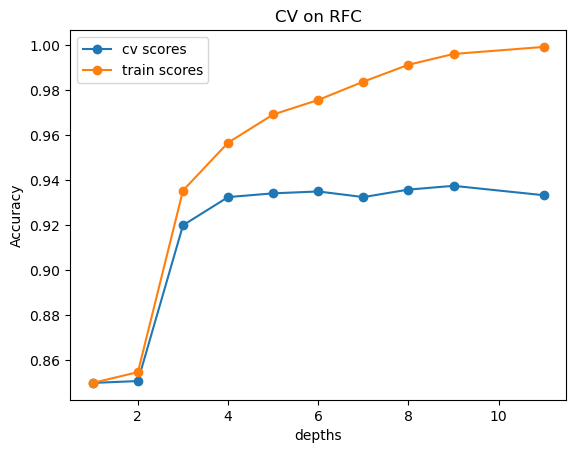

In [28]:
plt.plot(depth, scores_cv, marker = 'o', label = 'cv scores')
plt.plot(depth, scores_train, marker = 'o', label = 'train scores')
plt.title('CV on RFC')
plt.xlabel('depths')
plt.ylabel('Accuracy')
plt.legend()

I pick 5 as the maximum depth of the tree

best parameter choice: 7


Text(0, 0.5, 'RMS Error')

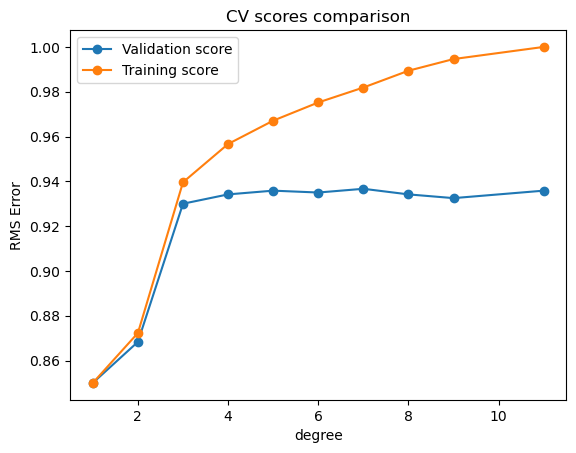

In [18]:
depth = np.linspace(1, 11, 10, dtype = int)
scores_cv = []
scores_train = []

grid = GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': depth}, cv=5, return_train_score = True) #Complete
#grid.fit(X_train, Y_train)
grid.fit(cv_x, cv_y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

plt.plot(depth, grid.cv_results_['mean_test_score'], marker = 'o', label = 'Validation score')
plt.plot(depth, grid.cv_results_['mean_train_score'], marker = 'o', label = 'Training score')
plt.legend()
plt.title('CV scores comparison')
plt.xlabel('degree')
plt.ylabel('RMS Error')

In [12]:
print(grid.scorer_)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>.score


In [324]:
# previous implementation using RMS

#depth = np.linspace(1, 11, 10, dtype = int)
#scores_cv = []
#scores_train = []

#cv_x_train, cv_y_train = shuffle(cv_x_train, cv_y_train)

#for i in depth:
    
 #   clf = RandomForestClassifier(max_depth = i, random_state=0)
  #  clf.fit(cv_x_train, cv_y_train)
   # scores_cv.append(- np.mean(cross_val_score(clf, cv_x_train, cv_y_train, cv = 10, scoring = 'neg_root_mean_squared_error')))

    #scores_train.append(RMS(cv_x_train, cv_y_train, clf))

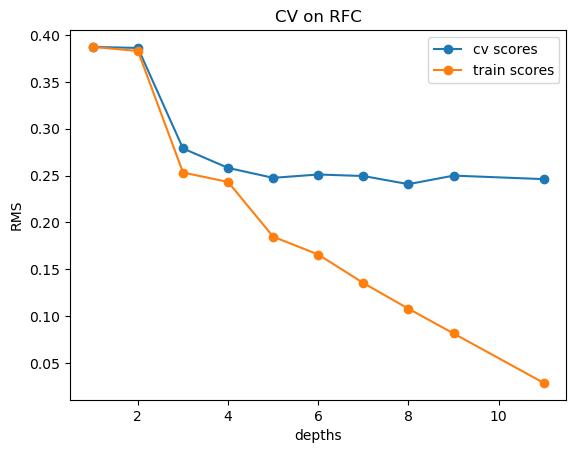

In [325]:
#plt.plot(depth, scores_cv, marker = 'o', label = 'cv scores')
#plt.plot(depth, scores_train, marker = 'o', label = 'train scores')
#plt.title('CV on RFC')
#plt.xlabel('depths')
#plt.ylabel('RMS')
#plt.legend()

**RMS:** For **depth = 4** the separation becomes important: 4 is the optimized depth in this case!

Now I can run the RFC for the training and the test and look at the true positives, true negatives, false positives, false negatives, completness and contamination from the confusion matrix.

Text(0.5, 23.52222222222222, 'Predicted label')

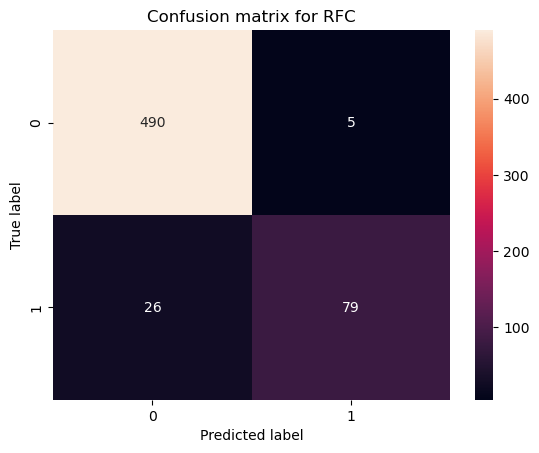

In [41]:
RFC_full = RandomForestClassifier(max_depth = 5, random_state=0)
RFC_full.fit(x_train, y_train)

y_pred_full = RFC_full.predict(x_test)
c_matrix_full = metrics.confusion_matrix(y_test, y_pred_full)

t_n_full, f_p_full, f_n_full, t_p_full = c_matrix_full.ravel()
completeness_full = t_p_full / (t_p_full + f_n_full)
contamination_full = f_p_full / (t_p_full + f_p_full)

accuracy_full = metrics.accuracy_score(y_test, y_pred_full)

sns.heatmap(c_matrix_full, annot = True, fmt="d")
plt.title('Confusion matrix for RFC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### RFC on PCA

In [22]:
pca_X_train, pca_x_test, pca_Y_train, pca_y_test = train_test_split(final_pca_features, data_sub['det'], test_size=0.2, random_state=42)
pca_cv_x, pca_x_train, pca_cv_y, pca_y_train =  train_test_split(pca_X_train, pca_Y_train, test_size=0.5, random_state=42)

In [23]:
depth = np.linspace(1, 11, 10, dtype = int)
pca_scores_cv = []
pca_scores_train = []

pca_cv_x, pca_cv_y = shuffle(pca_cv_x, pca_cv_y)

for i in depth:

    clf = RandomForestClassifier(max_depth = i, random_state = 0)
    clf.fit(pca_cv_x, pca_cv_y)
 
    pca_cv_results = cross_validate(clf, pca_cv_x, pca_cv_y, cv = 5, scoring = 'accuracy', return_train_score = True)
    pca_scores_cv.append(np.mean(pca_cv_results['test_score']))
    pca_scores_train.append(np.average(pca_cv_results['train_score']))
    

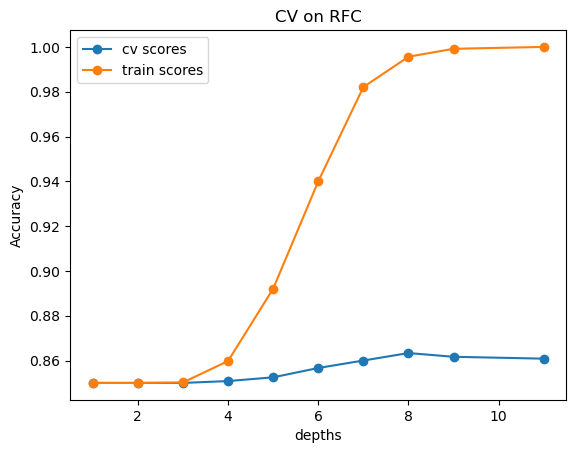

In [24]:
plt.plot(depth, pca_scores_cv, marker = 'o', label = 'cv scores')
plt.plot(depth, pca_scores_train, marker = 'o', label = 'train scores')
plt.title('CV on RFC')
plt.xlabel('depths')
plt.ylabel('Accuracy')
plt.legend()

I pick 3 as the maximum depth of the tree

In [334]:
# Previous implementation

#depth = np.linspace(1, 11, 10, dtype = int)
#scores_cv = []
#scores_train = []

#pca_cv_x, pca_cv_y = shuffle(pca_cv_x, pca_cv_y)

#for i in depth:
    
    #clf = RandomForestClassifier(max_depth = i, random_state=0)
    #clf.fit(pca_cv_x, pca_cv_y)
    #scores_cv.append(- np.mean(cross_val_score(clf, pca_cv_x, pca_cv_y, cv = 10, scoring = 'neg_root_mean_squared_error')))

    #scores_train.append(RMS(pca_cv_x, pca_cv_y, clf))

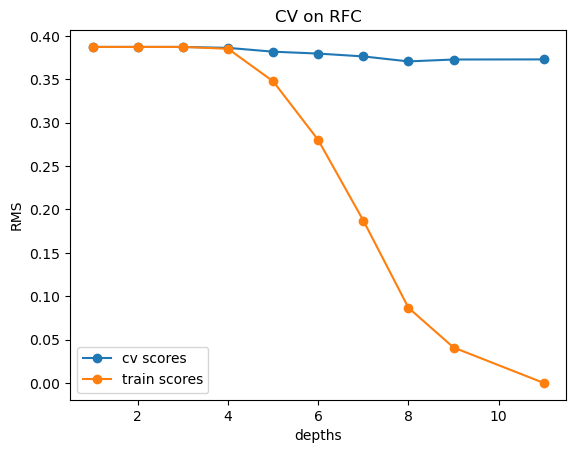

In [335]:
#plt.plot(depth, scores_cv, marker = 'o', label = 'cv scores')
#plt.plot(depth, scores_train, marker = 'o', label = 'train scores')
#plt.title('CV on RFC')
#plt.xlabel('depths')
#plt.ylabel('RMS')
#plt.legend()

**RMS:** I'll pick 4 also here

Text(0.5, 23.52222222222222, 'Predicted label')

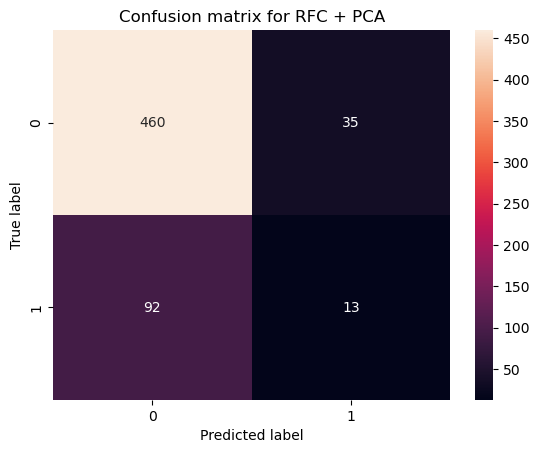

In [42]:
RFC_pca = RandomForestClassifier(max_depth = 3, random_state=0)
RFC_pca.fit(pca_x_train, pca_y_train)

pca_y_pred = RFC_full.predict(pca_x_test)
pca_c_matrix = metrics.confusion_matrix(pca_y_test, pca_y_pred)

t_n_pca, f_p_pca, f_n_pca, t_p_pca = pca_c_matrix.ravel()
completeness_pca = t_p_pca / (t_p_pca + f_n_pca)
contamination_pca = f_p_full / (t_p_pca + f_p_pca)


accuracy_pca = metrics.accuracy_score(pca_y_test, pca_y_pred)

sns.heatmap(pca_c_matrix, annot = True, fmt="d")
plt.title('Confusion matrix for RFC + PCA')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### RFC on T-SNE

Because PCA is not very usefull (the scree plot doesn't flatten), I can try with the six components T-SNE. I just picked six not to make the computational time too long and see if something change; I get comparable results with less components

In [26]:
X_train, tsne_x_test, Y_train, tsne_y_test = train_test_split(tsne_data, data_sub['det'], test_size=0.2, random_state=42)
tsne_cv_x, tsne_x_train, tsne_cv_y, tsne_y_train =  train_test_split(X_train, Y_train, test_size=0.5, random_state=42)

In [27]:
depth = np.linspace(1, 11, 10, dtype = int)
tsne_scores_cv = []
tsne_scores_train = []

tsne_cv_x, tsne_cv_y = shuffle(tsne_cv_x, tsne_cv_y)

for i in depth:

    clf = RandomForestClassifier(max_depth = i, random_state = 0)
    clf.fit(tsne_cv_x, tsne_cv_y)
 
    tsne_cv_results = cross_validate(clf, tsne_cv_x, tsne_cv_y, cv = 5, scoring = 'accuracy', return_train_score = True)
    tsne_scores_cv.append(np.mean(tsne_cv_results['test_score']))
    tsne_scores_train.append(np.average(tsne_cv_results['train_score']))
    

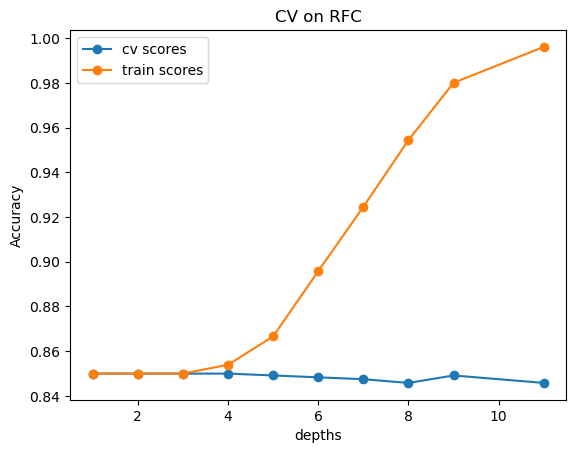

In [28]:
plt.plot(depth, tsne_scores_cv, marker = 'o', label = 'cv scores')
plt.plot(depth, tsne_scores_train, marker = 'o', label = 'train scores')
plt.title('CV on RFC')
plt.xlabel('depths')
plt.ylabel('Accuracy')
plt.legend()

I pick 3 as the best depth

In [345]:
#depth = np.linspace(1, 11, 10, dtype = int)
#scores_cv = []
#scores_train = []

#tsne_cv_x, tsne_cv_y = shuffle(tsne_cv_x, tsne_cv_y)

#for i in depth:
    
#    clf = RandomForestClassifier(max_depth = i, random_state=0)
 #   clf.fit(tsne_cv_x, tsne_cv_y)
  #  scores_cv.append(- np.mean(cross_val_score(clf, tsne_cv_x, tsne_cv_y, cv = 10, scoring = 'neg_root_mean_squared_error')))

   # scores_train.append(RMS(tsne_cv_x, tsne_cv_y, clf))

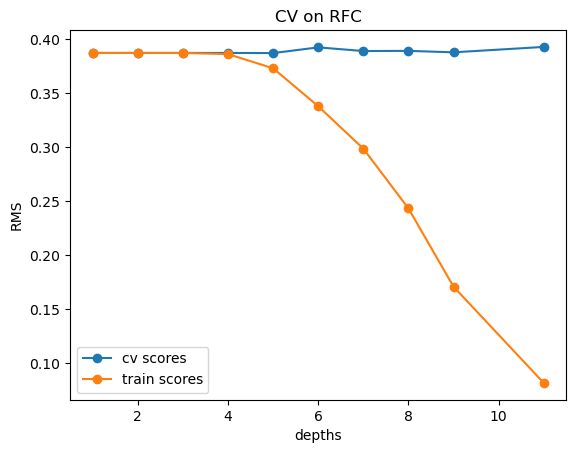

In [346]:
#plt.plot(depth, scores_cv, marker = 'o', label = 'cv scores')
#plt.plot(depth, scores_train, marker = 'o', label = 'train scores')
#plt.title('CV on RFC')
#plt.xlabel('depths')
#plt.ylabel('RMS')
#plt.legend()

**RMS:** Here 4 seems the best. 

[[495   0]
 [105   0]]


/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_93590/489661355.py:9: RuntimeWarning: invalid value encountered in scalar divide
  contamination_tsne = f_p_tsne / (t_p_tsne + f_p_tsne)


Text(0.5, 23.52222222222222, 'Predicted label')

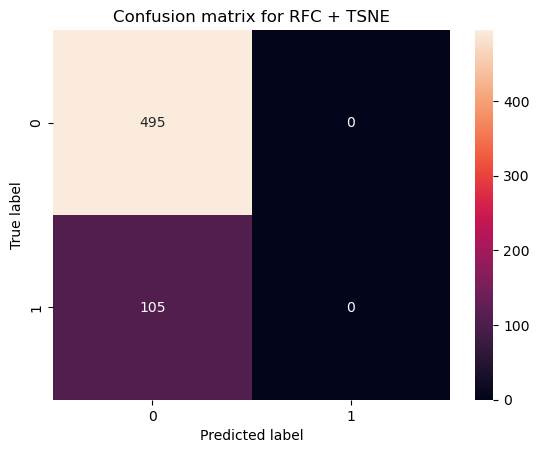

In [43]:
RFC_tsne = RandomForestClassifier(max_depth = 3, random_state=0)
RFC_tsne.fit(tsne_x_train, tsne_y_train)

y_pred_tsne = RFC_tsne.predict(tsne_x_test)
c_matrix_tsne = metrics.confusion_matrix(tsne_y_test, y_pred_tsne)

t_n_tsne, f_p_tsne, f_n_tsne, t_p_tsne = c_matrix_tsne.ravel()
completeness_tsne = t_p_tsne / (t_p_tsne + f_n_tsne)
contamination_tsne = f_p_tsne / (t_p_tsne + f_p_tsne)


accuracy_tsne = metrics.accuracy_score(tsne_y_test, y_pred_tsne)

sns.heatmap(c_matrix_tsne, annot = True, fmt="d")
plt.title('Confusion matrix for RFC + TSNE')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Of course, the classification here is terrible

## Regression on SNR

### Full dataset

In [46]:
x_train, x_test, y_train, y_test = train_test_split(scaled_data, data_sub['snr'], test_size=0.2, random_state=42)

In [49]:
def RFR_class (clf, X_train, X_test, Y_train, Y_test):

    RFR = clf(random_state=42)
    RFR.fit(X_train, Y_train)

    y_pred_RFR = RFR.predict(X_test)

    y_pred_RFR = (y_pred_RFR > 12)
    y_test_RFR = (Y_test > 12)

    RFR_accuracy = metrics.accuracy_score(y_test_RFR, y_pred_RFR)

    c_matrix = metrics.confusion_matrix(y_test_RFR, y_pred_RFR)

    t_n, f_p, f_n, t_p = c_matrix.ravel()
    completeness = t_p / (t_p + f_n)
    contamination = f_p / (t_p + f_p)

    print('Accuracy: %.02f' %RFR_accuracy)

    sns.heatmap(c_matrix, annot = True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return c_matrix, completeness, contamination, RFR_accuracy, 

Accuracy: 0.97


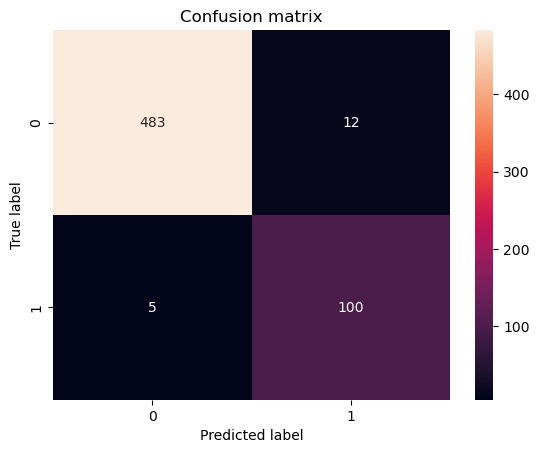

In [50]:
full_matrix, full_comp, full_cont, full_acc = RFR_class (RandomForestRegressor, x_train, x_test, y_train, y_test)

### RFR on PCA

In [51]:
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(final_pca_features, data_sub['snr'], test_size=0.2, random_state=42)

Accuracy: 0.80


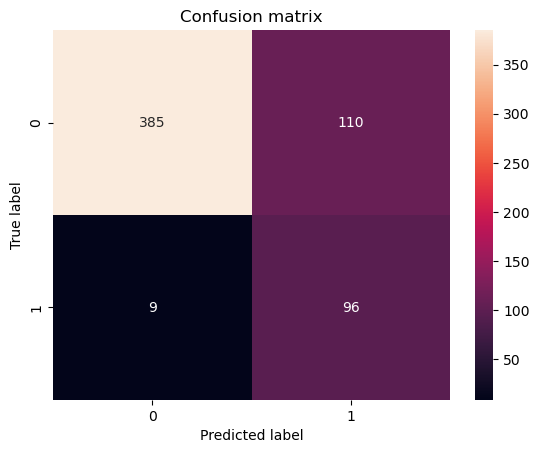

In [52]:
pca_matrix, pca_comp, pca_cont, pca_acc = RFR_class (RandomForestRegressor, pca_x_train, pca_x_test, pca_y_train, pca_y_test)

### RFR on T-SNE

In [53]:
tsne_x_train, tsne_x_test, tsne_y_train, tsne_y_test = train_test_split(tsne_data, data_sub['snr'], test_size=0.2, random_state=42)

Accuracy: 0.71


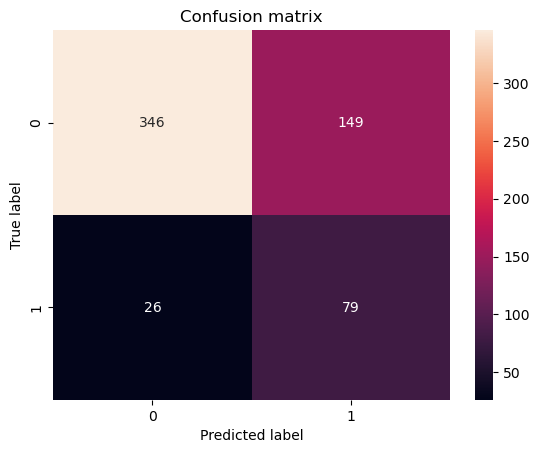

In [54]:
tsne_matrix, tsne_comp, tsne_cont, tsne_acc = RFR_class (RandomForestRegressor, tsne_x_train, tsne_x_test, tsne_y_train, tsne_y_test)

# Result recap

## Full dataset


 Classification with det 

Classification Completness: 0.75
Classification Contamination: 0.06
Classification Accuracy: 0.95

 Regression with SNR 

Regression Completness: 0.95
Regression Contamination: 0.11
Regression Accuracy: 0.97 



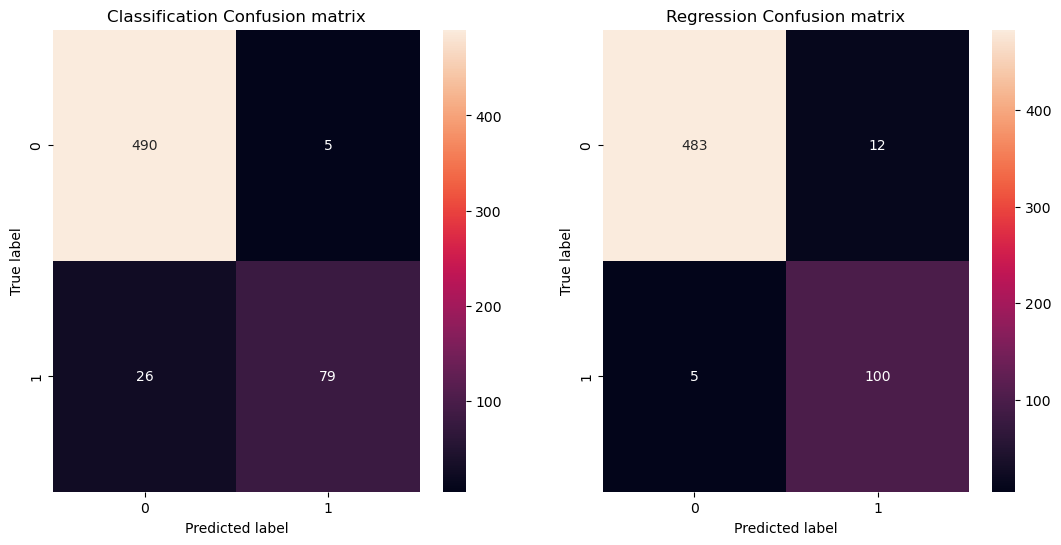

In [57]:
fig = plt.figure(figsize = (13, 6))

ax = plt.subplot(121)
sns.heatmap(c_matrix_full, annot = True, fmt="d")
plt.title('Classification Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = plt.subplot(122)
sns.heatmap(full_matrix, annot = True, fmt="d")
plt.title('Regression Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('\n', 'Classification with det', '\n')
print('Classification Completness: %.02f' %completeness_full)
print('Classification Contamination: %.02f' %contamination_full)
print('Classification Accuracy: %.02f' %accuracy_full)

print('\n', 'Regression with SNR', '\n')

print('Regression Completness: %.02f' %full_comp)
print('Regression Contamination: %.02f' %full_cont)
print('Regression Accuracy: %.02f' %full_acc, '\n')


## PCA


 Classification with det 

Classification Completness: 0.12
Classification Contamination: 0.10
Classification Accuracy: 0.79

 Regression with SNR 

Regression Completness: 0.91
Regression Contamination: 0.53
Regression Accuracy: 0.80 



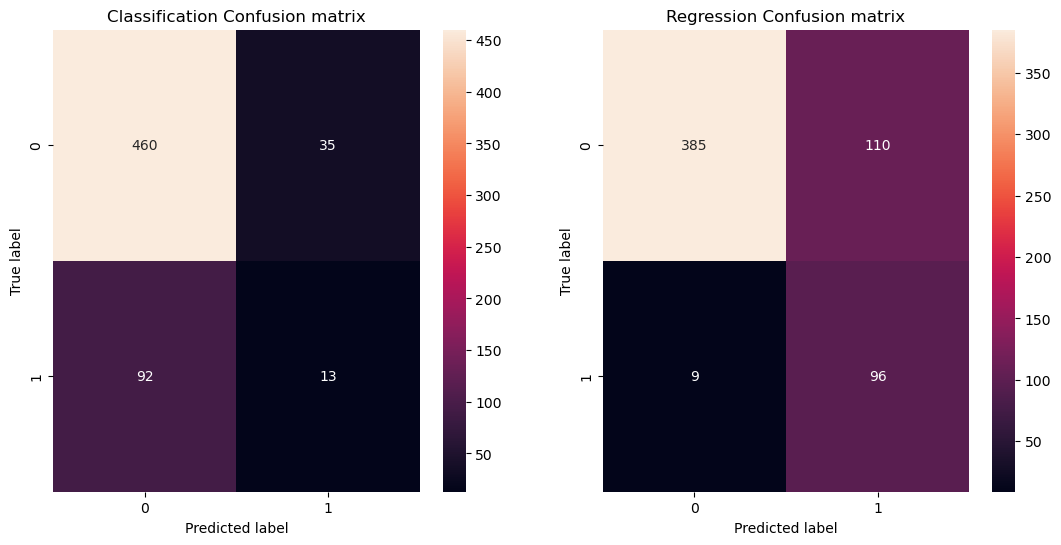

In [59]:
fig = plt.figure(figsize = (13, 6))

ax = plt.subplot(121)
sns.heatmap(pca_c_matrix, annot = True, fmt="d")
plt.title('Classification Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = plt.subplot(122)
sns.heatmap(pca_matrix, annot = True, fmt="d")
plt.title('Regression Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('\n', 'Classification with det', '\n')
print('Classification Completness: %.02f' %completeness_pca)
print('Classification Contamination: %.02f' %contamination_pca)
print('Classification Accuracy: %.02f' %accuracy_pca)

print('\n', 'Regression with SNR', '\n')

print('Regression Completness: %.02f' %pca_comp)
print('Regression Contamination: %.02f' %pca_cont)
print('Regression Accuracy: %.02f' %pca_acc, '\n')


## T-SNE


 Classification with det 

Classification Completness: 0.00
Classification Contamination: nan
Classification Accuracy: 0.82

 Regression with SNR 

Regression Completness: 0.75
Regression Contamination: 0.65
Regression Accuracy: 0.71 



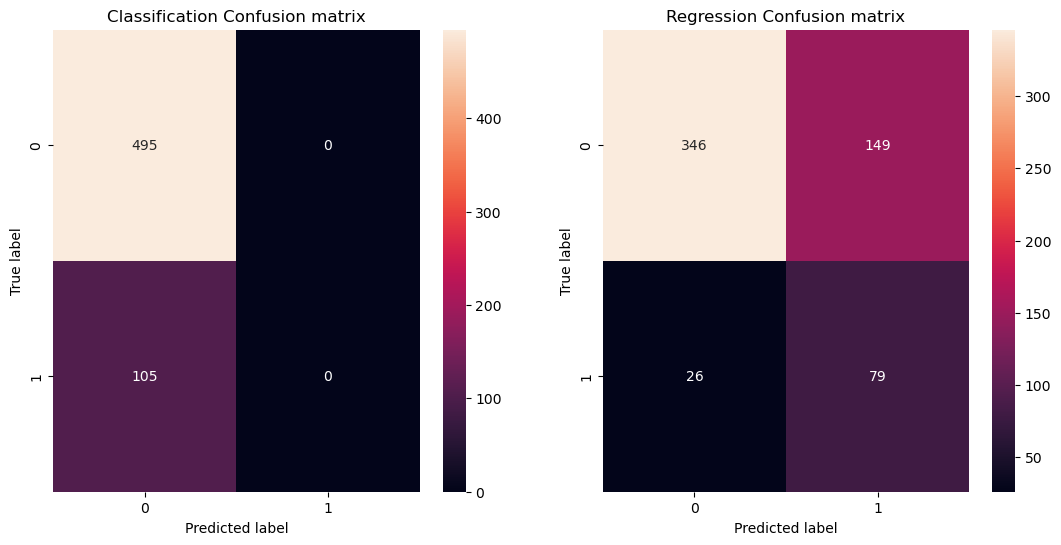

In [60]:
fig = plt.figure(figsize = (13, 6))

ax = plt.subplot(121)
sns.heatmap(c_matrix_tsne, annot = True, fmt="d")
plt.title('Classification Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = plt.subplot(122)
sns.heatmap(tsne_matrix, annot = True, fmt="d")
plt.title('Regression Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('\n', 'Classification with det', '\n')
print('Classification Completness: %.02f' %completeness_tsne)
print('Classification Contamination: %.02f' %contamination_tsne)
print('Classification Accuracy: %.02f' %accuracy_tsne)

print('\n', 'Regression with SNR', '\n')

print('Regression Completness: %.02f' %tsne_comp)
print('Regression Contamination: %.02f' %tsne_cont)
print('Regression Accuracy: %.02f' %tsne_acc, '\n')


## Bonus: why not Neaural Networks?

I try to takle this problem using a NN as in lecture 22, I will use the 'det' attribute.

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

In [62]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
data_sub = []
N_used = 100000

for name in (list(dataset.keys())):
    data_sub.append(dataset[name][:N_used])

In [63]:
data_sub = pd.DataFrame(np.transpose(data_sub))
data_sub.columns = list(dataset.keys())

In [64]:
data = data_sub[['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']]
print(data.shape)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

print(scaled_data.shape)

(100000, 12)
(100000, 12)


In [97]:
x_train, x_test, y_train, y_test = train_test_split(scaled_data, data_sub['det'], test_size = 0.2, random_state = 42)
x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)

In [98]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


First of all, I build a NN and try to optimize the parameters.

In [99]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([20, 25, 30, 35, 40]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [100]:
def train_test_model(hparams):
    
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation = 'sigmoid'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS] - 10, activation = 'sigmoid'),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS] - 15, activation = 'sigmoid'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
  ])
    
  model.compile(
      optimizer = hparams[HP_OPTIMIZER],
      loss = keras.losses.BinaryCrossentropy(),
      metrics = ['accuracy'],
  )

  model.fit(x_train, y_train, epochs = 10) 
  _, accuracy = model.evaluate(x_val, y_val)
  return accuracy

In [101]:
def run(run_dir, hparams):
    
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [102]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 20, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.7894 - loss: 0.5034
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8592 - loss: 0.3161
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.9187 - loss: 0.2028
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9245 - loss: 0.1830
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9325 - loss: 0.1677
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.9350 - loss: 0.1584
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9369 - loss: 0.1541
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9431 - loss: 0.1436
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9412 - loss: 0.1413
Epoch 10/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9439 - loss: 0.1358
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 261u

In [103]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 96142), started 0:22:08 ago. (Use '!kill 96142' to kill it.)

In [104]:
tuned_num_units = 35
tuned_dropout = 0.1
tuned_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Here other parameters that I will try:
act_func = 'sigmoid'
loss_function = keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary accuracy'),
           tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name = 'recall'),
          ]

In [105]:
def tuned_model (metrics, optimizer, units, t_dropout, loss_function, act_func):

    model = tf.keras.models.Sequential([

    tf.keras.layers.Flatten(input_shape = (x_train.shape[-1],), name = 'layers_flatten'),
    tf.keras.layers.Dense(units, activation = act_func , name = 'layers_dense_0'),
    tf.keras.layers.Dropout(t_dropout, name = 'layers_dropout_0'),
    tf.keras.layers.Dense(units - 10, activation = act_func , name = 'layers_dense_1'),
    tf.keras.layers.Dense(units - 15, activation = act_func , name = 'layers_dense_2'),
    tf.keras.layers.Dropout(t_dropout, name = 'layers_dropout_1'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
  ])
    
    model.compile(optimizer = optimizer,
                  loss = loss_function,
                  metrics = metrics)

    return model

In [107]:
t_model = tuned_model(metrics, tuned_optimizer, tuned_num_units, tuned_dropout, loss_function, act_func)
t_model.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layers_flatten (Flatten)        │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dense_0 (Dense)          │ (None, 35)             │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dropout_0 (Dropout)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dense_1 (Dense)          │ (None, 25)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dense_2 (Dense)          │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dropout_1 (Dropout)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,896 (7.41 KB)

 Trainable params: 1,896 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
training_res = t_model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val)) 

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary accuracy: 0.8576 - cross entropy: 0.3895 - loss: 0.3895 - precision: 0.3634 - recall: 0.0404 - val_binary accuracy: 0.9347 - val_cross entropy: 0.1633 - val_loss: 0.1633 - val_precision: 0.7358 - val_recall: 0.8476
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary accuracy: 0.9261 - cross entropy: 0.1671 - loss: 0.1671 - precision: 0.7511 - recall: 0.7487 - val_binary accuracy: 0.9400 - val_cross entropy: 0.1436 - val_loss: 0.1436 - val_precision: 0.7939 - val_recall: 0.7836
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary accuracy: 0.9314 - cross entropy: 0.1575 - loss: 0.1575 - precision: 0.7594 - recall: 0.7734 - val_binary accuracy: 0.9396 - val_cross entropy: 0.1404 - val_loss: 0.1404 - val_precision: 0.7732 - val_recall: 0.8169
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary accuracy: 0.9367 - cross entropy: 0.1480 - loss: 0.1480 - precision: 0.7714 - recall: 0.7971 - val_binary accur

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - binary accuracy: 0.9510 - cross entropy: 0.1150 - loss: 0.1150 - precision: 0.8138 - recall: 0.8477
loss : 0.114
compile_metrics : 0.952
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


Undetectable signlas classified as undetectable:  16600
Undectectable signals classified as Detectable:  524
Detectable signals classified as Undetectable:  429
Detectable signals classified as Detectable:  2447 



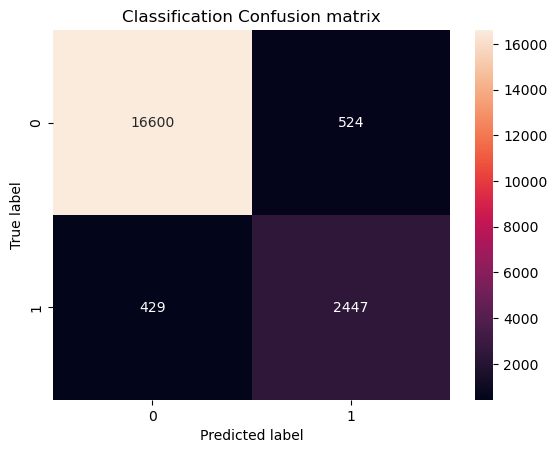

In [109]:
test_res = t_model.evaluate(x_test, y_test)

for name, value in zip(t_model.metrics_names, test_res):
  print(name, ': %.03f' %value)
conf_mat = skm.confusion_matrix(y_test, t_model.predict(x_test) > 0.5)


sns.heatmap(conf_mat, annot = True, fmt="d")
plt.title('Classification Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')


t_p, f_n, f_p, t_n = conf_mat.ravel()
print('\n')

print('Undetectable signlas classified as undetectable: ', t_p)
print('Undectectable signals classified as Detectable: ', f_n)
print('Detectable signals classified as Undetectable: ', f_p)
print('Detectable signals classified as Detectable: ', t_n, '\n')



 Classification with det 

Classification Completness: 0.75
Classification Contamination: 0.06
Classification Accuracy: 0.95

 Regression with SNR 

Regression Completness: 0.95
Regression Contamination: 0.11
Regression Accuracy: 0.97 



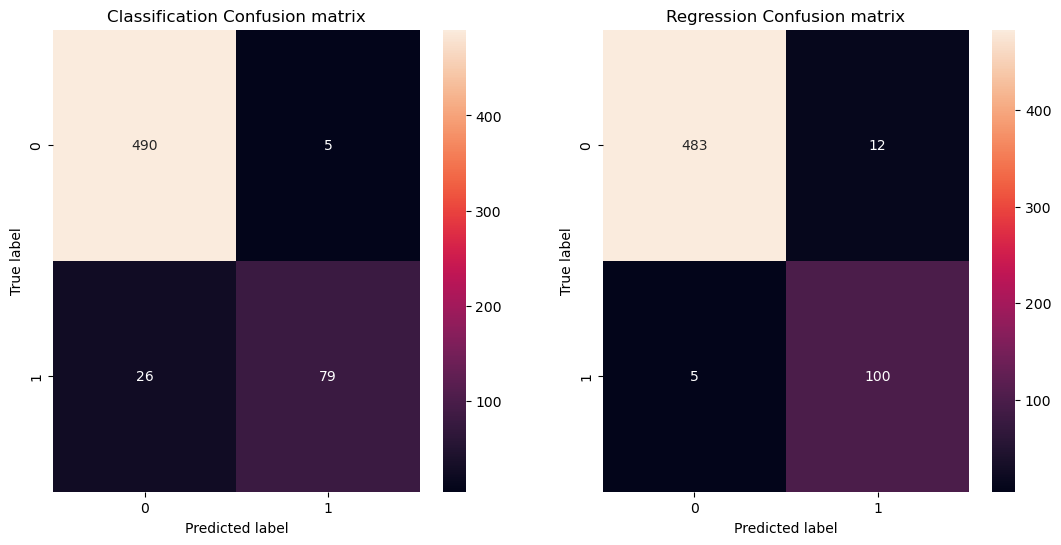

In [110]:
fig = plt.figure(figsize = (13, 6))

ax = plt.subplot(121)
sns.heatmap(c_matrix_full, annot = True, fmt="d")
plt.title('Classification Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = plt.subplot(122)
sns.heatmap(full_matrix, annot = True, fmt="d")
plt.title('Regression Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('\n', 'Classification with det', '\n')
print('Classification Completness: %.02f' %completeness_full)
print('Classification Contamination: %.02f' %contamination_full)
print('Classification Accuracy: %.02f' %accuracy_full)

print('\n', 'Regression with SNR', '\n')

print('Regression Completness: %.02f' %full_comp)
print('Regression Contamination: %.02f' %full_cont)
print('Regression Accuracy: %.02f' %full_acc, '\n')


The gain in accuracy is very small compared to the classification case using RFC on the full dataset. Using NN you gain a relatively large amount of completness but you loose a lot in precision, because with RFC the contamination is very low.

This was just a test with a 'random' NN, optimizing its architecture will provide better results probably.